#  Winning a Kaggle Competition in Python - Part 2

> Now that you know the basics of Kaggle competitions, you will learn how to study the specific problem at hand. You will practice EDA and get to establish correct local validation strategies. You will also learn about data leakage.

- toc: true
- branch: master
- badges: true
- comments: true
- author: Hai Nguyen
- categories: [Kaggle, Datacamp, Machine Learning, Python, EDA]
- image: images/winning_kaggle_p2.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

## 2.1 Understand the problem
- Solution workflow 

![sw](images/solution_workflow.png)

- Data type: tabular data, time series, images, text, etc.
- Problem type: classification, regression, ranking, etc.
- Evalation Metrics: ROC AUC, F1-Score, MAE, MSE, etc.
    - Example Custom Metric (Root Mean Squared Error in a Logarithmic scale):
     
    $$ RMSLE = \sqrt{\frac{1}{N}\sum_{i=1}^N (\log(y_i + 1) - \log(\hat{y_i} + 1))^2} $$
    


### 2.1.2 Define a competition metrics


In [10]:
import numpy as np
import pandas as pd 

# Import log_loss from sklearn
from sklearn.metrics import log_loss

# Define your own LogLoss function
def own_logloss(y_true, prob_pred):
  	# Find loss for each observation
    terms = y_true * np.log(prob_pred) + (1 - y_true) * np.log(1 - prob_pred)
    # Find mean over all observations
    err = np.mean(terms) 
    return -err

y_classification_true = np.array([  1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
                                    1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
                                    0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
                                    1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
                                    0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0])
y_classification_pred = np.array([  0.2082483 , 0.4433677 , 0.71560128, 0.41051979, 0.19100696,
                                    0.96749431, 0.65075037, 0.86545985, 0.02524236, 0.26690581,
                                    0.5020711 , 0.06744864, 0.99303326, 0.2364624 , 0.37429218,
                                    0.21401191, 0.10544587, 0.23247979, 0.30061014, 0.63444227,
                                    0.28123478, 0.36227676, 0.00594284, 0.36571913, 0.53388598,
                                    0.16201584, 0.59743311, 0.29315247, 0.63205049, 0.02619661,
                                    0.88759346, 0.01611863, 0.12695803, 0.77716246, 0.04589523,
                                    0.71099869, 0.97104614, 0.87168293, 0.71016165, 0.95850974,
                                    0.42981334, 0.87287891, 0.35595767, 0.92976365, 0.14877766,
                                    0.94002901, 0.8327162 , 0.84605484, 0.12392301, 0.5964869 ,
                                    0.01639248, 0.72118437, 0.00773751, 0.08482228, 0.22549841,
                                    0.87512453, 0.36357632, 0.53995994, 0.56810321, 0.22546336,
                                    0.57214677, 0.6609518 , 0.29824539, 0.41862686, 0.45308892,
                                    0.93235066, 0.58749375, 0.94825237, 0.55603475, 0.50056142,
                                    0.00353221, 0.48088904, 0.927455  , 0.19836569, 0.05209113,
                                    0.40677889, 0.37239648, 0.85715306, 0.02661112, 0.92014923,
                                    0.680903  , 0.90422599, 0.60752907, 0.81195331, 0.33554387,
                                    0.34956623, 0.38987423, 0.75479708, 0.36929117, 0.24221981,
                                    0.93766836, 0.90801108, 0.34879732, 0.63463807, 0.27384221,
                                    0.20611513, 0.33633953, 0.32709989, 0.8822761 , 0.82230381])

print('Your LogLoss: {:.5f}'.format(own_logloss(y_classification_true, y_classification_pred)))
print('Sklearn LogLoss: {:.5f}'.format(log_loss(y_classification_true, y_classification_pred)))



Your LogLoss: 1.10801
Sklearn LogLoss: 1.10801


## 2.2 Initial EDA 
##### Goals of EDA:
    - Size of the data
    - Properties of the target variable
    - Properties of the features
    - Generate ideas for feature engineering  
<br />


##### Example: Two sigma connect rental listing inquiries:

    - Predict the popularity of an apartment rental listing
    - target variable: interest_level
    - Problem type: Classification ( 3 classes: 'high', 'medium', 'low' )
    - Metric: Multi-class log loss


### 2.2.1 EDA. Part I

In [16]:
import pandas as pd 

twosigma_train = pd.read_json(open("datasets/two_sigma_connect/train.json"))
twosigma_test = pd.read_json(open("datasets/two_sigma_connect/test.json"))

print('Train shape:', twosigma_train.shape)
print('Test shape:', twosigma_test.shape)

Train shape: (49352, 15)
Test shape: (74659, 14)


In [17]:
print(twosigma_train.columns.tolist())
twosigma_train.rename(columns={'listing_id':'id'}, inplace=True)
twosigma_test.rename(columns={'listing_id':'id'}, inplace=True)

TO_KEEP = ['bathrooms', 'bedrooms', 'building_id', 'latitude', 'id', 'longitude', 'manager_id', 'price',  'interest_level']

for col in twosigma_train.columns.tolist():
    if col not in TO_KEEP:
        twosigma_train.drop([col], axis = 1, inplace = True) 
        twosigma_test.drop([col], axis = 1, inplace = True) 

print(twosigma_train.columns.tolist())

['bathrooms', 'bedrooms', 'building_id', 'created', 'description', 'display_address', 'features', 'latitude', 'listing_id', 'longitude', 'manager_id', 'photos', 'price', 'street_address', 'interest_level']
['bathrooms', 'bedrooms', 'building_id', 'latitude', 'id', 'longitude', 'manager_id', 'price', 'interest_level']


In [18]:
print(twosigma_train.interest_level.value_counts())

low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64


In [27]:
twosigma_train.set_index('id', inplace = True)
twosigma_test.set_index('id', inplace = True)


twosigma_train.describe()

,bathrooms,bedrooms,latitude,longitude,price
count,49352.00000,49352.000000,49352.000000,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,0.000000,4.490000e+06


In [28]:
twosigma_train.head(10)

,bathrooms,bedrooms,building_id,latitude,longitude,manager_id,price,interest_level
id,,,,,,,,
7170325,1.0,1,8579a0b0d54db803821a35a4a615e97a,40.7108,-73.9539,a10db4590843d78c784171a107bdacb4,2400,medium
7092344,1.0,2,b8e75fc949a6cd8225b455648a951712,40.7513,-73.9722,955db33477af4f40004820b4aed804a0,3800,low
7158677,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,40.7575,-73.9625,c8b10a317b766204f08e613cef4ce7a0,3495,medium
7211212,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,40.7145,-73.9425,5ba989232d0489da1b5f2c45f6688adc,3000,medium
7225292,1.0,0,bfb9405149bfff42a92980b594c28234,40.7439,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,2795,low
7226687,1.0,3,300d27d8ba2adbcbc8c6f2bcbc1c6f9d,40.7348,-73.9865,30a7951cfc21240e8c46b2d079d292e5,7200,low
7126989,2.0,3,0d01cabe55fa5192cdbcabd5c585c1ea,40.7302,-73.9826,9f39caedae295bf81e67463e6fd0af40,6000,low
7114138,1.0,0,d48767c37a934daaf0bbb0e58c755d0c,40.7769,-73.9467,9cbfa7a31ae9dfba70b4383636d99788,1945,high
7131094,0.0,1,d1ca33a2853e64fad6e4009d5d5d168f,40.7346,-73.9811,b89e62bf8cdc98e9fb8b97d9bc627197,2435,low


### 2.2.2 EDA. Part II

Draw some plots

In [23]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# find the median price by the interest level
prices = twosigma_train.groupby('interest_level', as_index=False)['price'].median()

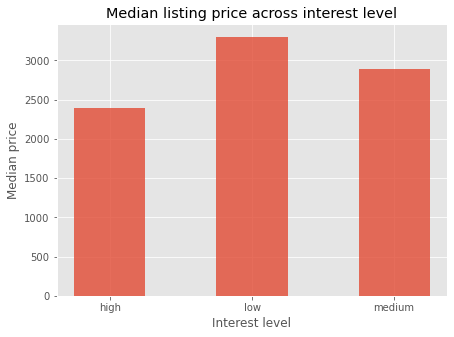

In [25]:
# Draw a barplot
fig = plt.figure(figsize=(7,5))
plt.bar(prices.interest_level, prices.price, width=0.5, alpha = 0.8)

plt.xlabel('Interest level')
plt.ylabel('Median price')
plt.title('Median listing price across interest level')

plt.show()
""" This shows that lower median price get high interest level, while higher prices get low interest level. """

In [33]:
twosigma_train.interest_level.value_counts()

low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64

## 2.3 Local validation
- K-fold cross-validation
- Stratified K-fold  
 

## 2.4 Validation usage
- Time K-fold
- Overall validation score.  
 